In [14]:
import numpy as np
import random
import pandas as pd
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import shutil
from glob import glob

import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

Using TensorFlow backend.


2.2.0


Creating Directories for test and train:

In [0]:
os.makedirs('train')
os.makedirs('test')
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['COVID', 'NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

Extracting data from the directories by using os.listdir(pathname):

In [0]:
covid_images=os.listdir('covid')
noncovid_images=os.listdir('/content/drive/My Drive/noncovid')

Number of Samples of each Class:

In [29]:
print('Number of covid images: ',len(covid_images))
print('Number of Non-covid images: ',len(noncovid_images))

Number of covid images:  263
Number of Non-covid images:  285


Splitting the data into test and train and moving the data into the directories using shutil.copy(source path, destination path):

In [0]:
test_ratio=0.15
random.shuffle(covid_images)
random.shuffle(noncovid_images)

number_of_images_covid = int(test_ratio*len(covid_images))
number_noncovid=int(test_ratio*len(noncovid_images))

### test images ###
for image in covid_images[:number_of_images_covid] :
  shutil.copy("/content/covid/" +image, "/content/test/COVID")

for image in noncovid_images[:number_noncovid] :
  shutil.copy("/content/drive/My Drive/noncovid/" +image, "/content/test/NonCOVID")

### train images ###
for image in covid_images[number_of_images_covid:]:
  shutil.copy("/content/covid/" +image, "/content/train/COVID")

for image in noncovid_images[number_noncovid:] :
  shutil.copy("/content/drive/My Drive/noncovid/" +image, "/content/train/NonCOVID")

Displaying random images one from each covid and non-covid cases.It displays random images for every cell run

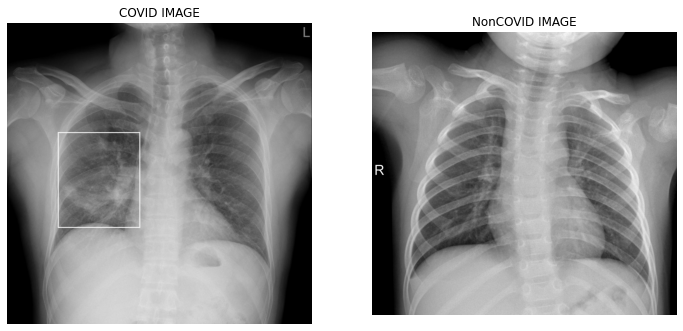

In [95]:
n=random.randint(0,200)
positive_image=cv2.imread('covid/'+covid_images[n])
negative_image=cv2.imread('/content/drive/My Drive/noncovid/'+noncovid_images[n])
f = plt.figure(figsize=(12,12))
f.add_subplot(1, 2, 1)
plt.title('COVID IMAGE')
plt.imshow(positive_image)
plt.axis(False)
f.add_subplot(1,2, 2)
plt.imshow(negative_image)
plt.title('NonCOVID IMAGE')
plt.axis(False)
plt.show()

Creating ImageDataGenerator() for image prepoccessing and rescaling the image by dividing every pixel with 255 which brings the pixel of every image between 0 and 1.

In [0]:
train_image_genarator=ImageDataGenerator(rescale=1./255)
test_image_genarator=ImageDataGenerator(rescale=1./255)

Flow_from_directory used to set the target image size , batch size and class mode (binary or catogorial) by taking the directory path as one of the parameter.

In [113]:
train_image_gen=train_image_genarator.flow_from_directory('/content/train',
                                                          target_size=(150,150),
                                                          batch_size=64,
                                                          class_mode='binary')
validation=test_image_genarator.flow_from_directory('/content/test',
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    class_mode='binary')

Found 467 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


Class Labels:

In [64]:
train_image_gen.class_indices

{'COVID': 0, 'NonCOVID': 1}

### Creating model:

In [0]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(150,150,3)))
model.add(Conv2D(32,(3,3),activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])


In [116]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 128)      

Fitting the model for training:

In [117]:
history = model.fit(
      train_image_gen,
      steps_per_epoch=7,
      epochs=5,
      validation_data=validation,
      validation_steps=5,
      )

Epoch 1/5
7/7 [==============================] - 46s 7s/step - loss: 0.6765 - accuracy: 0.6328 - val_loss: 0.6625 - val_accuracy: 0.6500
Epoch 2/5
7/7 [==============================] - 49s 7s/step - loss: 0.3349 - accuracy: 0.9040 - val_loss: 0.0525 - val_accuracy: 0.9692
Epoch 3/5
7/7 [==============================] - 42s 6s/step - loss: 0.0749 - accuracy: 0.9665 - val_loss: 0.1113 - val_accuracy: 0.9538
Epoch 4/5
7/7 [==============================] - 49s 7s/step - loss: 0.0251 - accuracy: 0.9911 - val_loss: 0.0540 - val_accuracy: 0.9846
Epoch 5/5
7/7 [==============================] - 44s 6s/step - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0011 - val_accuracy: 1.0000


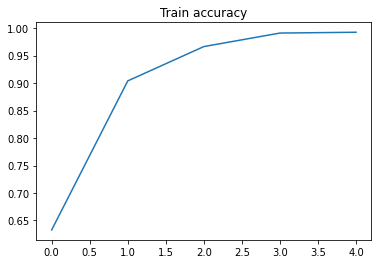

In [128]:
l=history.history
plt.plot(l['accuracy'])
plt.title('Train accuracy')
plt.show()

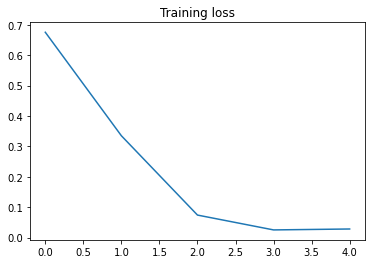

In [129]:
plt.plot(l['loss'])
plt.title('Training loss')
plt.show()

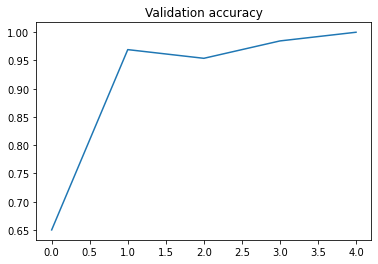

In [130]:
plt.plot(l['val_accuracy'])
plt.title('Validation accuracy')
plt.show()

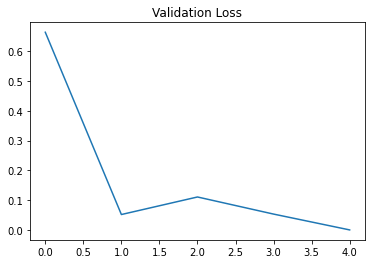

In [132]:
plt.plot(l['val_loss'])
plt.title('Validation Loss')
plt.show()

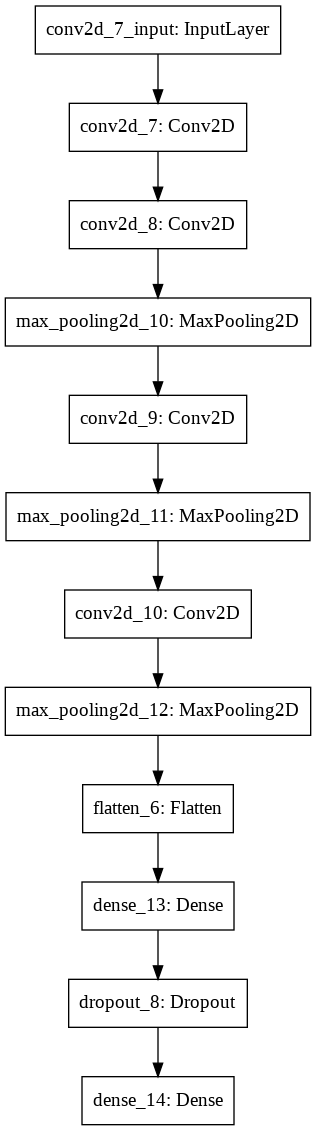

In [133]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

**Conclusion:**
              This model works as a two class classifier (COVID [0] & NonCOVID[1] ).Here the dataset is very small dues to lack of data collection.Transfer learning is preferred while using large amount of data.


**Note:** It's just a basic model and not preffered to use in real world situations.